# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

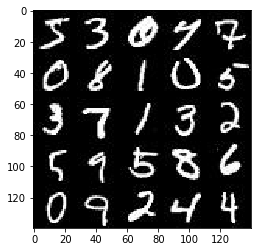

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

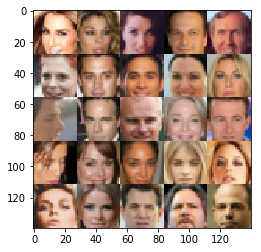

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images_ = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels))
    z_random_ = tf.placeholder(tf.float32,(None, z_dim))
    learning_rate_ = tf.placeholder(tf.float32)
    
    return (real_images_, z_random_, learning_rate_)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #input layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        x1 = tf.maximum(0.2*x1, x1)
        #layer now 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2*x2, x2)
        #layer now 7x7x128
        
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2*x3, x3)
        #layer now 4x4x256
        
        
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        z1 = tf.layers.dense(z,(7*7*512))
        
         # Reshape it to start the convolutional stack
        x1 = tf.reshape(z1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x256 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)

        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)

    d_out_real, d_logits_real =  discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake =  discriminator(g_model, reuse=True)

    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_real, labels = tf.ones_like(d_out_real)* (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.zeros_like(d_out_real)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    
    return (d_train_opt,g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.5823
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 1.7508
Epoch 1/2... Discriminator Loss: 1.9940... Generator Loss: 0.2547
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 1.8570
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.9789
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.9097


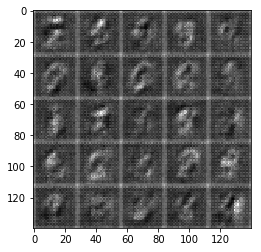

Epoch 1/2... Discriminator Loss: 0.9743... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.8104
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.6338
Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.6655
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 1.6605
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 2.0694


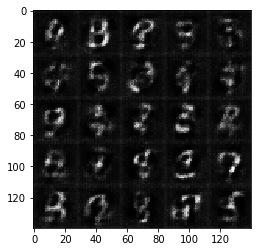

Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 1.4975
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.3904
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.2076
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 1.3946
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 1.6047


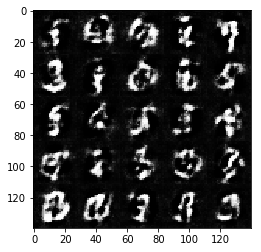

Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.9222
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.9272
Epoch 1/2... Discriminator Loss: 0.7089... Generator Loss: 1.7361
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.5150
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 1.7142
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 1.5697
Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 1.7946
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.0328


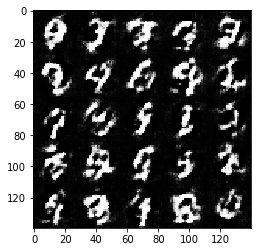

Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 2.1119
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 2.0500
Epoch 1/2... Discriminator Loss: 0.6575... Generator Loss: 1.8569
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 1.9438
Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 1.7648
Epoch 1/2... Discriminator Loss: 0.6246... Generator Loss: 1.8878
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 0.8459
Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.3672
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 1.6426
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 1.5916


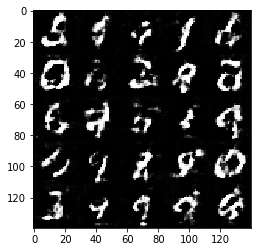

Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 0.6385... Generator Loss: 1.7891
Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 1.9695
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 1.5118
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 2.7509
Epoch 1/2... Discriminator Loss: 0.7557... Generator Loss: 1.5511
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 0.7175... Generator Loss: 1.3137
Epoch 1/2... Discriminator Loss: 0.7095... Generator Loss: 1.6324
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 2.3009


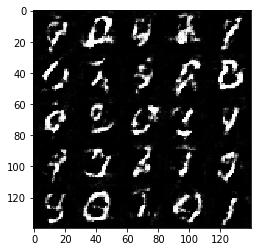

Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.3657
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 2.0548
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 2.2124
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 2.8350
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 0.9192
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 1.4076
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.5060


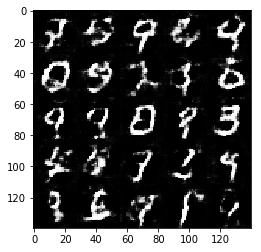

Epoch 1/2... Discriminator Loss: 1.9469... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: 0.7355... Generator Loss: 1.5770
Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 1.2128
Epoch 1/2... Discriminator Loss: 0.6815... Generator Loss: 1.8964
Epoch 1/2... Discriminator Loss: 0.7213... Generator Loss: 2.2505
Epoch 1/2... Discriminator Loss: 0.8156... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 0.8386... Generator Loss: 1.2643
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 0.9498... Generator Loss: 0.8833


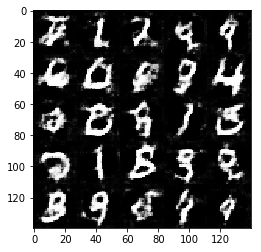

Epoch 1/2... Discriminator Loss: 0.7859... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 1.7587
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.8234
Epoch 1/2... Discriminator Loss: 0.6484... Generator Loss: 1.9977
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.4334
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 1.5186
Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 1.3939
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.5774
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 1.1129


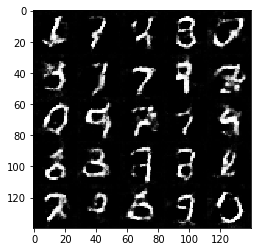

Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.5977
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 1.1687
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.3752
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.6323
Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 1.1744
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 1.2891


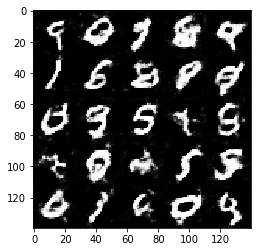

Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.7087
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.9453
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.6647
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.5784
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.5334
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.7568
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.9487


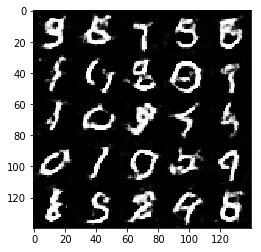

Epoch 2/2... Discriminator Loss: 0.6608... Generator Loss: 2.1965
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.0372
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 2.1507
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.0332
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 2.2710
Epoch 2/2... Discriminator Loss: 0.7605... Generator Loss: 1.4952
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.6360
Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 1.5589


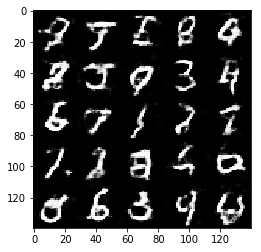

Epoch 2/2... Discriminator Loss: 0.7938... Generator Loss: 1.9968
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 2.7896
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 2.0811
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.7169
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.5016
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.9577
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 1.5671
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.0762


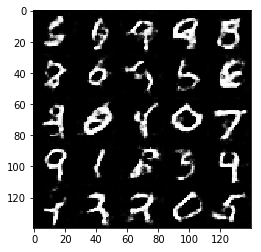

Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.0388... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.9274
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.6254
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.3857
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.2793
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 2.5584
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 2.0220
Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.4017


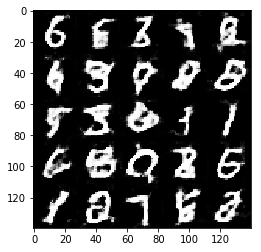

Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.4549
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 1.1840
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.7615
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.8154
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 1.3637
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.1304
Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 0.6437... Generator Loss: 1.7565


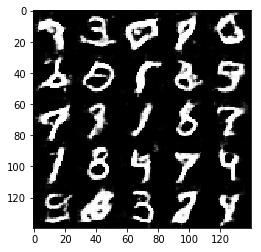

Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 1.6349
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.6707
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.4176
Epoch 2/2... Discriminator Loss: 0.8947... Generator Loss: 1.9348
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.4829
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.2114
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 1.5474
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.5443


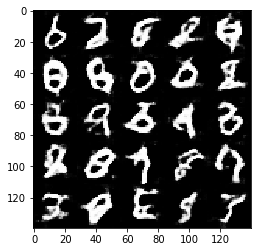

Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.2053
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.1416
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 2.1430
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 1.6726
Epoch 2/2... Discriminator Loss: 0.6674... Generator Loss: 1.5648
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 2.6231
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.4894
Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.6909
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.1080


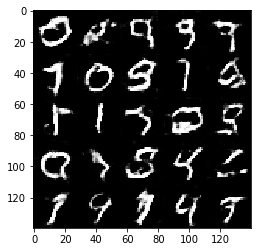

Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.6523
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.5519
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 2.5013
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.4546
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.4530
Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 2.9125
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.2905


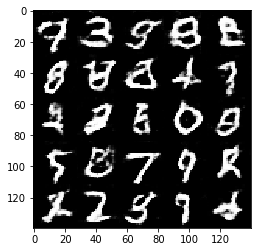

Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 0.7001... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.4791
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.7243
Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.8286


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8604... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.5858
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.4924
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.8306
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8205


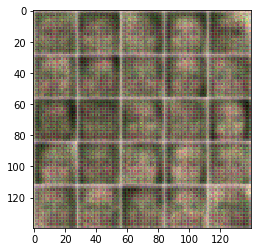

Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.2049


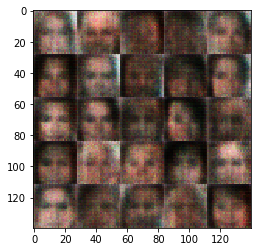

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.4090


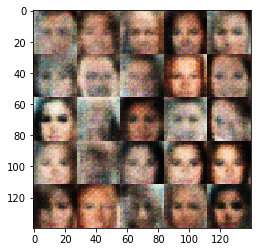

Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.6669
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.2791
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7614


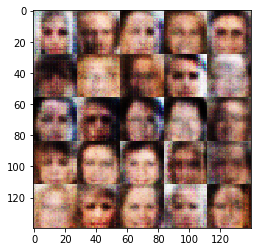

Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 1.4764
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.5707


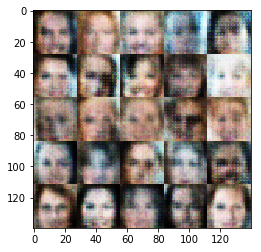

Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9188


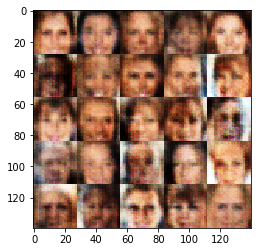

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8784


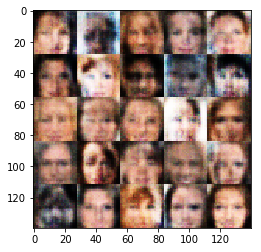

Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.0133


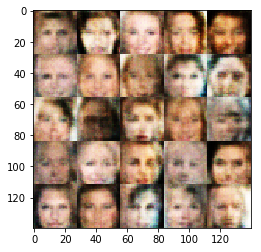

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8001


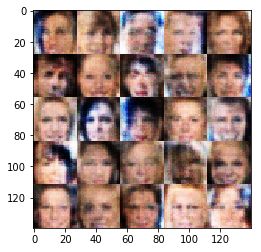

Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.0532


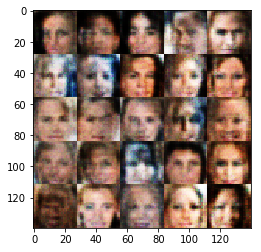

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6650


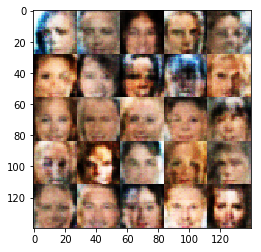

Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.7707
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 2.0578
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.9198
Epoch 1/1... Discriminator Loss: 1.9432... Generator Loss: 2.8770
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 2.0989


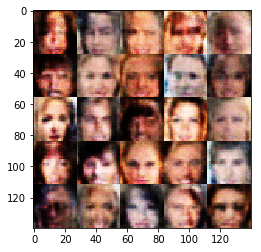

Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.6347
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.8992


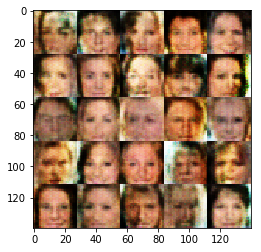

Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.2772


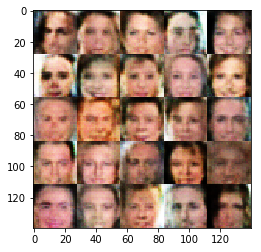

Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 2.0146
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 2.2881
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 2.1683


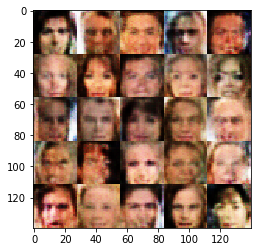

Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.7478
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 2.0275


In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.